In [35]:
#Linking the data with SQL Database
from sqldb import readcsv
df_full=readcsv.stemload()
df_full=df_full.replace('NA',np.NaN)
df_full['timestamp']= pd.to_datetime(df_full['timestamp'])
df_full['basesalary']=df_full.basesalary.astype(str).astype(float)
df_full['totalyearlycompensation']=df_full['totalyearlycompensation'].astype(str).astype(float)
df_full['yearsofexperience']=df_full.yearsofexperience.astype(float)
df_full['yearsatcompany']=df_full.yearsatcompany.astype(float)



root
Empty DataFrame
Columns: [timestamp, company, level, title, totalyearlycompensation, location, yearsofexperience, yearsatcompany, tag, basesalary, stockgrantvalue, bonus, gender, otherdetails, cityid, dmaid, rowNumber, Masters_Degree, Bachelors_Degree, Doctorate_Degree, Highschool, Some_College, Race_Asian, Race_White, Race_Two_Or_More, Race_Black, Race_Hispanic, Race, Education]
Index: []

[0 rows x 29 columns]
Done


## 1. Data Pre-processing

In [36]:
from src.learnlibs.preproc import *
from src.learnlibs.meanfill import *
from src.learnlibs.model import *
from src.learnlibs.read_data import *
from src.learnlibs.create_features import *
from src.learnlibs.splitdata import *
from learnlibs.metrics import *

### Load dataset

In [37]:
# df_full = loader("Levels_Fyi_Salary_Data.csv").load()
# remove not useful columns
df = df_full[['timestamp', 'company', 'level', 'title', 'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary', 'gender', 'Race', 'Education']]
df.head()

,timestamp,company,level,title,location,yearsofexperience,yearsatcompany,tag,basesalary,gender,Race,Education
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,"Redwood City, CA",1.5,1.5,NaN,107000.0,NaN,NaN,NaN
1,2017-06-10 17:11:29,eBay,SE 2,Software Engineer,"San Francisco, CA",5.0,3.0,NaN,0.0,NaN,NaN,NaN
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,"Seattle, WA",8.0,0.0,NaN,155000.0,NaN,NaN,NaN
3,2017-06-17 00:23:14,Apple,M1,Software Engineering Manager,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,NaN,NaN,NaN
4,2017-06-20 10:58:51,Microsoft,60,Software Engineer,"Mountain View, CA",5.0,3.0,NaN,0.0,NaN,NaN,NaN


### Check missing values

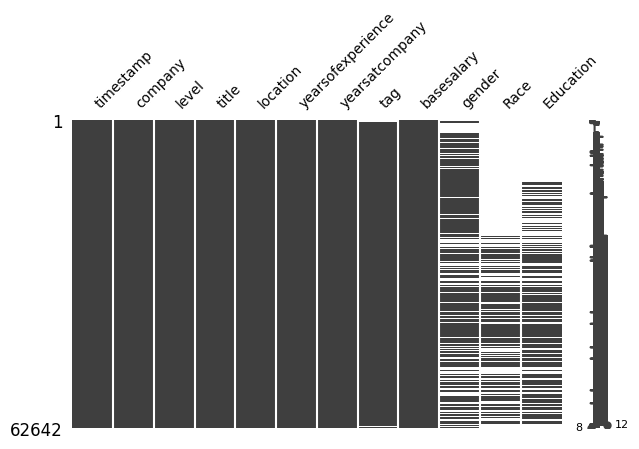

In [38]:
import matplotlib.pyplot as plt
import missingno as msno
msno.matrix(df, figsize=(7, 4), fontsize=10)
plt.show()

### Remove specific missing values

In [39]:
df = remove_nan(df,['level','company','basesalary','tag']).drop_nan()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61819 entries, 409 to 62641
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          61819 non-null  datetime64[ns]
 1   company            61819 non-null  object        
 2   level              61819 non-null  object        
 3   title              61819 non-null  object        
 4   location           61819 non-null  object        
 5   yearsofexperience  61819 non-null  float64       
 6   yearsatcompany     61819 non-null  float64       
 7   tag                61819 non-null  object        
 8   basesalary         61819 non-null  float64       
 9   gender             42774 non-null  object        
 10  Race               22410 non-null  object        
 11  Education          30344 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 6.1+ MB


### Fill categorical features

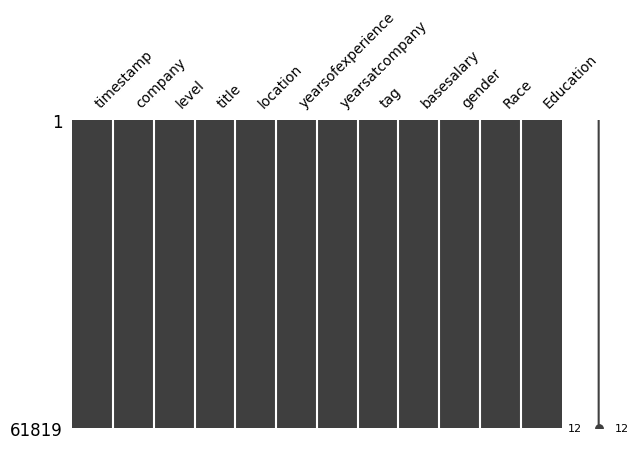

In [40]:
df = nan_filler(df,['gender','Race','Education']).fill_unavailable()
msno.matrix(df, figsize=(7, 4), fontsize=10)
plt.show()

In [41]:
#pd.to_datetime(df['timestamp'])

## 2. Creation of Features

### 2.1 Features of time

In [42]:
df = time(df,'timestamp').year()
df = time(df,'timestamp').month()
df = time(df,'timestamp').day()

### 2.2 Features of clusters

In [43]:
#cluster(df, 'basesalary', 'level').make_cluster()
df = cluster(df, 'basesalary', 'company').make_cluster()
df = cluster(df, 'basesalary', 'level').make_cluster()

### 2.3 Creating dummies

In [44]:
df.loc[df['gender'] == 'Title: Senior Software Engineer', 'gender'] = 'Unavailable'
df = dummies(df,['title','gender', 'Race', 'Education']).get_dum()

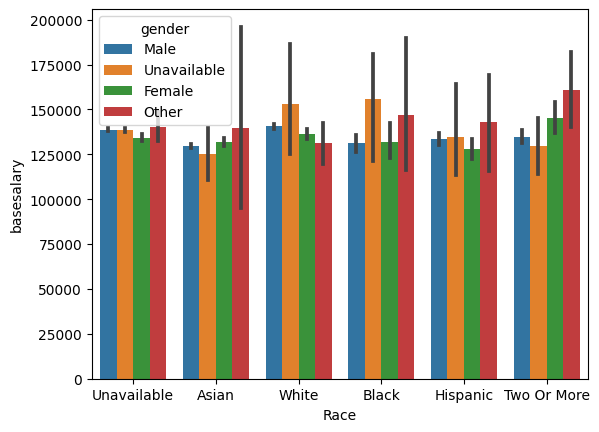

In [45]:
import seaborn as sns
sns.barplot(x = 'Race', hue =  'gender', y = 'basesalary', data = df)
plt.show()

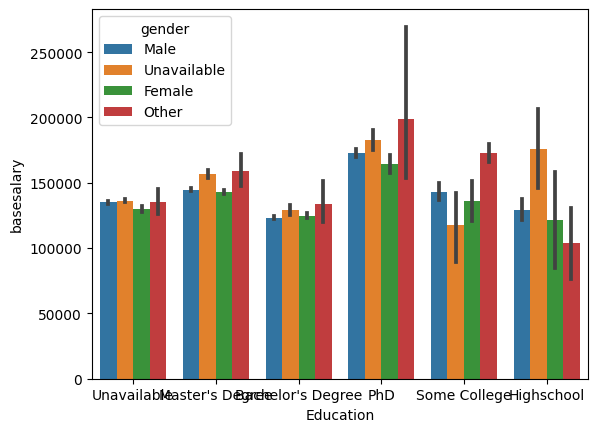

In [46]:
sns.barplot(x = 'Education', hue =  'gender', y = 'basesalary', data = df)
plt.show()

### Practitioner section

In [47]:
# I remove very low salary values which could be results of failed scraping, and very high values (2% of outliers)
df = df[df['basesalary'] > 10 ]
q98 = np.quantile(df['basesalary'],0.98)
df.loc[ df.basesalary >q98 , 'basesalary'] =q98

#years_ratio
df['years_ratio'] = 0
df.loc[ df['yearsofexperience'] >0 ,'years_ratio'] = df['yearsatcompany']/df['yearsofexperience']

#cities
common_locs = df.value_counts('location').head(10).reset_index().location.to_list()
df = df.join(pd.get_dummies(df.loc[df.location.isin(common_locs), 'location'] ) )
df[common_locs] = df[common_locs].fillna(0)

#countries
df['country'] = df['location'].str.split(pat=',').apply(lambda x:x[-1][1:])
df.loc[ df['country'].str.len() == 2,'country'] = 'US'
df['country'].value_counts().head(6)

#one_hot the common ones
df = df.join(pd.get_dummies(df['country'])[['US', 'India', 'Canada', 'United Kingdom', 'Germany']])

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59607 entries, 0 to 61818
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   timestamp                           59607 non-null  datetime64[ns]
 1   company                             59607 non-null  object        
 2   level                               59607 non-null  object        
 3   title                               59607 non-null  object        
 4   location                            59607 non-null  object        
 5   yearsofexperience                   59607 non-null  float64       
 6   yearsatcompany                      59607 non-null  float64       
 7   tag                                 59607 non-null  object        
 8   basesalary                          59607 non-null  float64       
 9   gender                              59607 non-null  object        
 10  Race                  

## 3. Model

### 3.1 Split into train and test

In [49]:
X = df[['yearsofexperience','years_ratio','yearsatcompany','company_encoded', 'level_encoded',
        'timestamp_month','timestamp_year', 'gender_Male',  'gender_Other', 'gender_Unavailable', 
        'Race_Black', 'Race_Hispanic', 'Race_Two Or More', 'Race_Unavailable', 'Race_White',
        'Education_Highschool', 'Education_Master\'s Degree', 'Education_PhD',
        'Education_Some College', 'Education_Unavailable',
        'title_Data Scientist','title_Hardware Engineer', 'title_Human Resources', 'title_Management Consultant',
        'title_Marketing', 'title_Mechanical Engineer', 'title_Product Designer','title_Product Manager', 'title_Recruiter', 
        'title_Sales', 'title_Software Engineer','title_Software Engineering Manager', 'title_Solution Architect',
        'title_Technical Program Manager',
        'US', 'India', 'Canada', 'United Kingdom', 'Germany' # improved a lot by adding countries! 
        ]
        + common_locs
        ]

y = df['basesalary']

In [50]:
X_train, X_test, y_train, y_test = split(X, y).split_train_test()

### 3.2 Regression and prediction

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from learnlibs.model import *
# rf = RandomForestClassifier()
clf2 = RandomForestRegressor(random_state=0)  
hyperparams = {'n_estimators': 20,
               'max_features': 'auto',
               'max_depth': 7,
               'min_samples_split': 5,
               'min_samples_leaf': 5 }
# Training the model on the train set
mod=model(X_train,y_train,clf2,hyperparams)

/home/djtom/bse/.venv/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [52]:
#predicting the values in test
y_pred=mod.predict(X_test)

## 4. Evaluation

In [53]:
modelscore=calc_score(y_test,y_pred)
r2_val, mse_val=modelscore.r2(), modelscore.mse()
print(r2_val,mse_val)

0.7792676143549765 23244.172573920834
